In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import spatial
%matplotlib inline
from tqdm import tqdm

In [2]:
def grid(N, spacing=1.0):
    x, y = np.meshgrid(np.arange(N), np.arange(N), sparse=False, indexing='xy')
    ratio = np.sqrt(3) / 2 
    y = y * ratio  # condense along y axus
    x = x * 1.0  # Cast to float
    x[1::2, :] += 0.5  # Shift every other row of the grid
    
    return x.flatten() * spacing, y.flatten()*spacing
    

In [3]:
spacing = 4.156

In [1266]:
x, y = grid(20, spacing)

In [1453]:

data = pd.DataFrame({'x': x, 'y': y, 'r': 2})

## First test the translational order on a perfect grid

In [254]:
def get_G(spacing, a):
    cosa = np.cos(a*np.pi/180)
    sina = np.sin(a*np.pi/180)
    return np.array((cosa, sina))*4*np.pi/(spacing*np.sqrt(3))

In [255]:
def add_torder(data, spacing, angle):
    G = get_G(spacing, angle)
    print(f"G = {G}")
    data['torder'] = np.exp(1j * data[['x', 'y']].values@G)
    return data

In [256]:
def plot_torder(data):
    plt.scatter(data.x, data.y, c=np.angle(data.torder))
    plt.colorbar()
    
def quiver_torder(data):
    torder = data.torder.values
    plt.quiver(data.x, data.y, torder.real, torder.imag, np.angle(torder), pivot='mid', cmap='hsv')
    plt.clim([-np.pi, np.pi])
    plt.colorbar()

In [1490]:
spacing

4.156

For angle = 90

G = [1.06894302e-16 1.74571642e+00]


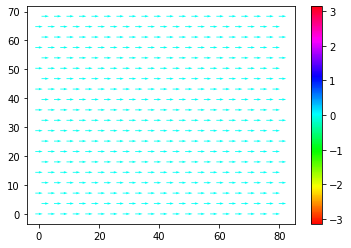

In [1491]:
%matplotlib inline
data = add_torder(data, spacing, 90)
quiver_torder(data)

For angle = 60 + 90 = 150

In [78]:
data = add_torder(data, spacing, 150)
quiver_torder(data)

NameError: name 'data' is not defined

For sanity check angle = 60

G = [0.87285821 1.51183477]


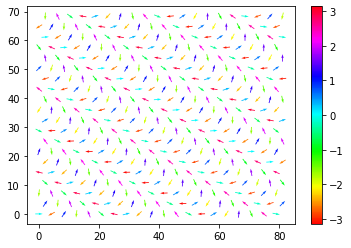

In [1493]:
data = add_torder(data, spacing, 60)
quiver_torder(data)

## Then add noise to the grid and test again

In [7]:
def add_noise(data, D):
    data = data.copy()
    noise = np.random.normal(0, D, len(data))
    data['x'] += noise
    noise = np.random.normal(0, D, len(data))
    data['y'] += noise
    return data
    

In [1495]:
data_noisy = add_noise(data, 0.3)

For angle = 90

G = [1.06894302e-16 1.74571642e+00]


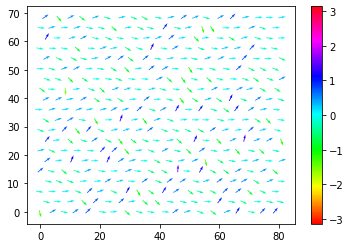

In [1496]:
data_noisy = add_torder(data_noisy, spacing, 90)
quiver_torder(data_noisy)

## Remove some particles and test

In [1497]:
def remove_random(data, percent):
    remove = np.random.rand(len(data))*100 > percent
    return data.loc[remove].copy()

In [1498]:
less_data = remove_random(data, 50)

G = [1.06894302e-16 1.74571642e+00]


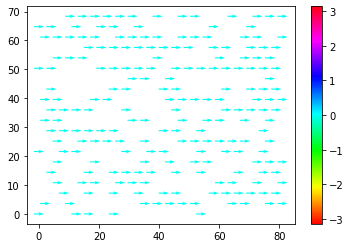

In [1499]:
less_data = add_torder(less_data, spacing, 90)
quiver_torder(less_data)

## Check orientational order too

In [491]:
from particletracking.statistics.order import order_process_long

In [1457]:
def quiver_order(d):
    order = d.order_r_long.values + 1j*d.order_i_long.values
    plt.quiver(d.x, d.y, order.real, order.imag, np.angle(order), pivot='mid', cmap='hsv')
    plt.clim([-np.pi, np.pi])
    plt.colorbar()

In [1458]:
def add_order(d):
    d = order_process_long(d)
    d = d.loc[d.neighbors_long==6].copy()
    d['order'] = d.order_r_long + 1j*d.order_i_long
    return d

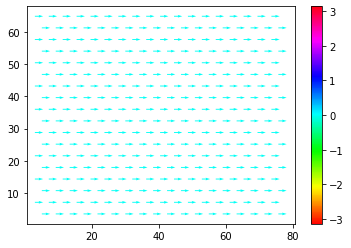

In [1459]:
data_order = add_order(data)
quiver_order(data_order)

## Add noise to orientational order

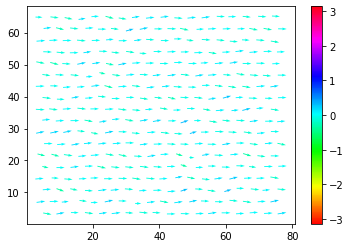

In [1461]:
data_order_noisy = add_noise(data, 0.2)
data_order_noisy = add_order(data_order_noisy)
quiver_order(data_order_noisy)

## Create multiple frames with different noise

In [79]:
noisy_datas = [add_noise(data, 0.1) for _ in range(50)]

NameError: name 'data' is not defined

In [538]:
noisy_datas = [add_torder(d) for d in noisy_datas]

In [555]:
average_torder = np.array([np.mean(d.torder) for d in noisy_datas])

In [556]:
sus = np.mean(average_torder*np.conj(average_torder)) - np.mean(average_torder)*np.conj(np.mean(average_torder))

In [568]:
sus

(5.902714764417452e-05+0j)

In [566]:
sus2 = np.abs(np.mean(average_torder**2) -np.mean(average_torder)**2)

In [567]:
sus2

5.7847121665828586e-05

## Load a real dataset from a flat plate system

In [80]:
from particletracking import dataframes

In [81]:
data_flat = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Flat2/17500093.hdf5")

#### Find the angle of the crystal

In [82]:
flat_points = data_flat.df.loc[0].copy()

In [83]:
def get_angle(data):
    boundary = data.metadata['boundary']
    dx = boundary[1, 0] - boundary[0, 0]
    dy = boundary[1, 1] - boundary[0, 1]
    angle = np.arctan(dy/dx)
    return (angle * 180 / np.pi)

In [84]:
flat_angle = get_angle(data_flat)
flat_angle

-59.07143743126008

#### Find the distance between particles

In [85]:
def get_neighbor_distance(points):
    tree = spatial.KDTree(points)
    dists, _ = tree.query(points, 6)
    return dists[:, 1]
    
def get_particle_distance(points):
    dists = get_neighbor_distance(points[['x', 'y']])
    return np.mean(dists)

In [86]:
flat_spacing = get_particle_distance(flat_points)
flat_spacing

37.651193167718574

#### Calculate torder

G = [0.16529548 0.09903926]


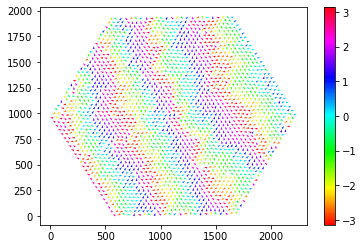

In [94]:
flat_points = add_torder(flat_points, flat_spacing, flat_angle + 90)
quiver_torder(flat_points)

# Try for dimpled data

In [10]:
data_dimpled = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/17480099.hdf5")

In [67]:
dimpled_points = data_dimpled.df.loc[0].copy()

In [142]:
dimpled_angle = get_angle(data_dimpled)
dimpled_spacing = get_particle_distance(dimpled_points)
dimpled_angle, dimpled_spacing

(-59.07143743126008, 37.75195339654827)

G = [-0.13589229  0.13589229]


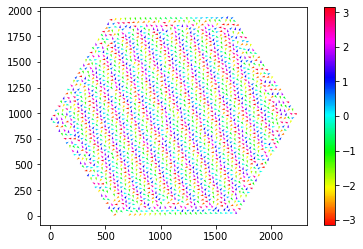

In [143]:
%matplotlib inline
dimpled_points = add_torder(dimpled_points, dimpled_spacing, 45+90)
quiver_torder(dimpled_points)

### Explore more ways of finding the distance

In [98]:
%matplotlib qt
plt.scatter(dimpled_points.x, dimpled_points.y)

In [137]:
vor = spatial.Voronoi(dimpled_points[['x', 'y']])

In [257]:
tri = spatial.Delaunay(dimpled_points[['x', 'y']])

In [258]:
tri.simplices

array([[2167, 2080, 1099],
       [2167, 2046, 2278],
       [1900, 1810, 2065],
       ...,
       [ 569, 1752, 1010],
       [ 363, 1752,  179],
       [1752, 1415,  179]], dtype=int32)

In [259]:
triangles =tri.points[tri.simplices]

In [260]:
vecs = np.array([t - t[[2, 0, 1], :] for t in triangles])

In [261]:
vecs_flat = vecs.reshape((-1, 2))

In [262]:
lengths = np.linalg.norm(vecs_flat, axis=1)
lengths

array([43.10452412, 44.41846463, 40.31128874, ..., 54.7813837 ,
       39.05124838, 45.69463864])

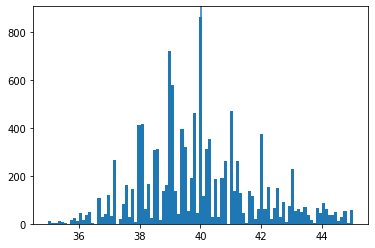

In [263]:
length_freq, length_bins, _ = plt.hist(lengths, bins=np.linspace(35, 45, 100))
plt.axvline(np.median(lengths))

In [264]:
length = np.median(lengths)

In [265]:
angles = np.arctan(vecs_flat[:, 1]/ vecs_flat[:, 0])

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


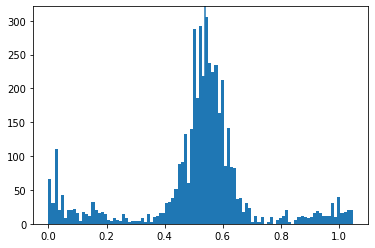

In [266]:
plt.hist(angles, bins=np.linspace(0, np.pi/3, 100))
plt.axvline(np.median(angles[(angles>0)&(angles<np.pi/3)]))

In [267]:
angle = np.median(angles[(angles>0)&(angles<np.pi/3)])*180/np.pi

In [268]:
angle

30.96375653207352

G = [-0.09329006  0.15548343]


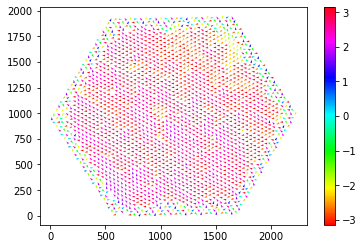

In [269]:
dimpled_points = add_torder(dimpled_points, length, angle+90)
quiver_torder(dimpled_points)

In [219]:
def get_G(length, angle):
    print(G)
    angle += 90
    cosa = np.cos(a*np.pi/180)
    sina = np.sin(a*np.pi/180)
    return np.array((cosa, sina))*4*np.pi/(spacing*np.sqrt(3))

In [220]:
def add_torder_G(data, G):
    data['torder'] = np.exp(1j * data[['x', 'y']].values@G)
    return data

In [284]:
def get_G_from_delaunay(points):
    tri = spatial.Delaunay(points[['x', 'y']].values)
    triangles = tri.points[tri.simplices]
    vecs = np.array([[t - t[[2, 0, 1], :] for t in triangles]])
    vecs = vecs.reshape((-1, 2))
    lengths = np.linalg.norm(vecs, axis=1)
    plt.figure()
    plt.hist(lengths, bins=np.linspace(35, 45, 100))
#     lengths = lengths[(lengths>35)&(lengths<45)]
    length = np.median(lengths)
    plt.axvline(length)
    angles = np.arctan(vecs[:, 1]/vecs[:, 0])
    plt.figure()
    plt.hist(angles, bins=np.linspace(0, np.pi, 100))
    angles = angles[(angles>0)&(angles<np.pi/3)]
    angle = np.median(angles)
    plt.axvline(angle)
    angle *= 180/np.pi
    print(angle)
    G = get_G(length, angle)
    points = add_torder(points, length, angle+90)
    plt.figure()
    quiver_torder(points)
    return G

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


30.96375653207352
G = [-0.09329006  0.15548343]


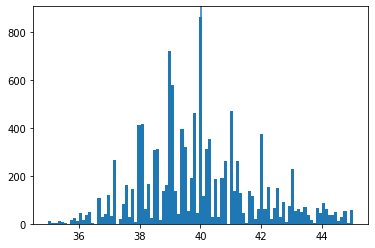

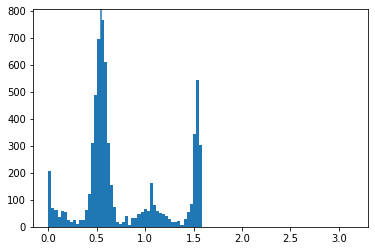

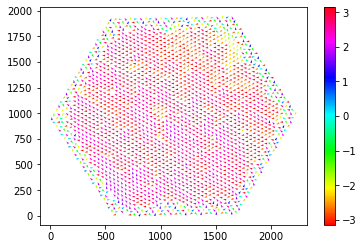

In [285]:
G = get_G_from_delaunay(dimpled_points)
# dimpled_points = add_torder_G(dimpled_points, G)
# plt.figure()
# quiver_torder(dimpled_points)

7.305759533310825
G = [-0.02303628  0.17968297]


/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


array([0.17968297, 0.02303628])

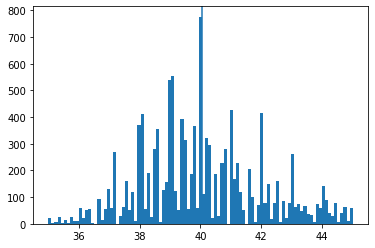

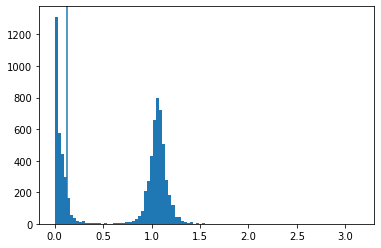

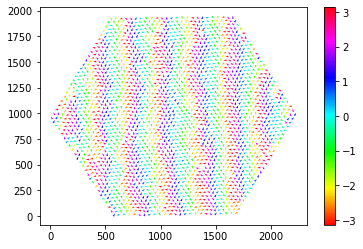

In [286]:
get_G_from_delaunay(flat_points)

## Get G from the structure factor $s(k)$

Easiest way is to make an image with particle positions and then do a fourier transform

### Do this for perfect crystal first

In [808]:
x, y = grid(101, 4.16)
r = np.full_like(x, 2)

In [809]:
xmin, xmax, ymin, ymax = min(x), max(x), min(y), max(y)

In [810]:
im = np.zeros((int(1.1*ymax*10), int(1.1*xmax*10), 3))

In [811]:
circles = np.array((x, y, r)).T*10

In [812]:
im = images.draw_circles(im, circles, thickness=-1)[:, :, 1]

In [813]:
plt.imshow(im)

In [814]:
dist = images.distance_transform(im.astype(np.uint8))

In [772]:
s_of_k = np.abs(np.fft.fft2(dist))

In [773]:
plt.imshow(np.log(s_of_k))

In [703]:
from skimage.feature import peak_local_max

In [815]:
section = s_of_k[10:200, 10:200]
max_ = np.unravel_index(np.argmax(section), section.shape)
max_

(45, 101)

In [816]:
plt.imshow(np.log(s_of_k))
plt.plot(max_[1]+10, max_[0]+10, 'x')

In [817]:
sample_spacing = 0.1
window_length = len(dist)

In [820]:
k = np.array(max_) + 10
G = k / (sample_spacing*window_length)
G

array([0.13881878, 0.28016153])

In [821]:
data_perfect = pd.DataFrame({'x': x, 'y': y, 'r': 2})

In [824]:
data_perfect['torder'] = np.exp(1j*data_perfect[['x', 'y']].values@G[::-1])

In [825]:
plot_torder(data_perfect)

## Try sampling multiple Gs

In [974]:
x, y = grid(100, 1)

In [1025]:
# length = np.linspace(1, 20, 10000)
length = 4*np.pi/np.sqrt(3)

In [1026]:
angles = np.linspace(0, 2*np.pi, 10000)

In [1027]:
Gx = length*np.cos(angles)

In [1028]:
Gy = length*np.sin(angles)

In [1029]:
G = np.array((Gx, Gy)).T

In [1030]:
torders = np.sum(np.exp(1j*G@np.array((x, y))), axis=1)

In [1031]:
plt.plot(angles, np.abs(torders))

In [1019]:
x

array([ 0. ,  1. ,  2. , ..., 97.5, 98.5, 99.5])

In [1020]:

G = np.array((0, 4*np.pi/np.sqrt(3)))

In [1021]:
torders = np.exp(1j*G@np.array((x, y)))

In [1023]:
plt.scatter(x, y, c=np.angle(torders))

In [1033]:
import os, psutil
process = psutil.Process(os.getpid())
process.memory_info().rss/1e9

9.057644544

## Load dimpled data and try $|G|=\frac{4\pi}{a\sqrt{3}}$

In [1034]:
dimpled = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/17480090.hdf5")

In [1123]:
f = dimpled.df.loc[0]

In [1038]:
points = f[['x', 'y']].values

In [1040]:
dimpled_tree = spatial.KDTree(points)

In [1041]:
dists, _ = dimpled_tree.query(points, 6)

In [1043]:
dists.shape

(2280, 6)

In [1079]:
neighbour_distances = dists[:, 1]

In [1085]:
neighbour_distance = np.mean(neighbour_distances)

In [1091]:
dimpled.df.index.max()

1487

In [1096]:
all_neighbour_distances = []
for fi in tqdm(range(dimpled.df.index.max())):
    f = dimpled.df.loc[0][['x', 'y']].values
    tree = spatial.cKDTree(f)
    dists, _ = tree.query(f, 2)
    all_neighbour_distances.append(dists[:, 1])

100%|██████████| 1487/1487 [00:03<00:00, 395.32it/s]


In [1098]:
all_neighbour_distances = np.stack(all_neighbour_distances)

In [1101]:
all_neighbour_distances = all_neighbour_distances.flatten()

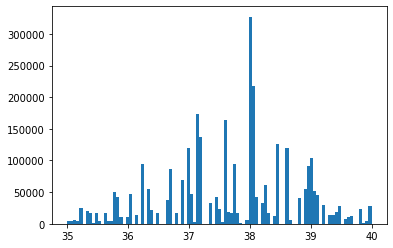

In [1106]:
freq, bins, _ = plt.hist(all_neighbour_distances, bins=np.linspace(35, 40, 100))

In [1107]:
a = bins[np.argmax(freq)]
a

37.97979797979798

In [1108]:
G_length = 2*np.pi/(a*np.sqrt(3))

In [1115]:
angles = np.linspace(0, np.pi, 1000)

In [1116]:
G = np.array((np.cos(angles), np.sin(angles)))*G_length

In [1117]:
torders = np.exp(1j*points@G)

In [1062]:
torders.shape

(2280, 1000)

In [1118]:
torders_each = np.sum(torders, axis=0)

In [1119]:
%matplotlib auto
plt.plot(angles, np.abs(torders_each))

Using matplotlib backend: Qt5Agg


In [1120]:
best_angle = angles[np.argmax(np.abs(torders_each))]

In [1121]:
G = np.array((np.cos(best_angle), np.sin(best_angle)))*G_length

In [1122]:
torders = np.exp(1j*points@G)

In [1125]:
plt.scatter(f.x, f.y, c=np.angle(torders))

### Try using pdist

In [1130]:
pair_dists = spatial.distance.pdist(points)

In [1148]:
freq, bins, _ = plt.hist(pair_dists, bins=np.linspace(30, 50, 100))

In [1150]:
dr = bins[1]-bins[0]

In [1151]:
N = len(points)

In [1152]:
g = freq / (2*np.pi*bins[:-1]*dr)

In [1154]:
plt.plot(bins[:-1], g)

In [1155]:
best_dist = bins[np.argmax(g)]
best_dist

38.888888888888886

In [1158]:
def pair_correlation(points, bins):
    pair_dists = spatial.distance.pdist(points)
    freq, bins, _ = plt.hist(pair_dists, bins=bins)
    dr = bins[1]-bins[0]
    N = len(points)
    g = freq / (2*np.pi*bins[:-1]*dr)
    return g

In [1159]:
gs = []
bins = np.linspace(30, 50, 200)
for fi in tqdm(range(dimpled.df.index.max())):
    f = dimpled.df.loc[0][['x', 'y']].values
    g = pair_correlation(f, bins)
    gs.append(g)

100%|██████████| 1487/1487 [06:12<00:00,  3.99it/s]


In [1165]:
g_of_r = np.stack(gs)

In [1166]:
g_of_r = np.sum(g_of_r, axis=0)

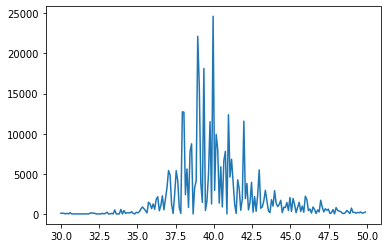

In [1170]:
%matplotlib inline
plt.plot(bins[:-1], g_of_r)

In [1174]:
dimpled.df.r.mean()

17.95268471477527

### Sample multiple Gs using new maths

In [1177]:
r = np.round(dimpled.df.r.mean())
r

18.0

In [1178]:
amin = 2*r
amax = 2.5*r

In [1210]:
a_trials = np.linspace(amin, amax, 100)
a_trials.shape

G_lengths = 2*np.pi / (a_trials * np.sqrt(3))

In [1244]:
angles = np.linspace(0, np.pi, 80)
angles.shape

(80,)

In [1261]:
points = dimpled.df.loc[0, ['x', 'y']].values
summed_torders = []
for l in G_lengths:
        G = np.array((np.cos(angles), np.sin(angles)))*l
        torders = np.exp(1j*points@G)
        summed_torders.append(np.var(np.angle(torders, axis=0)))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2280 is different from 2)

In [1252]:
var_torders_grid = np.stack(summed_torders)
var_torders_grid.shape

(100, 80)

In [1253]:
%matplotlib auto
plt.imshow(np.abs(summed_torders_grid))
plt.colorbar()

Using matplotlib backend: Qt5Agg


In [1235]:
a = angles[47]
G_length = G_lengths[89]
G = np.array((np.cos(a), np.sin(a)))*G_length

In [1236]:
torder = np.exp(1j*points@G)

In [1239]:
plt.scatter(points[:, 0], points[:, 1], c=np.angle(torder))

In [1254]:
a = angles[47]
G_length = G_lengths[43]
G = np.array((np.cos(a), np.sin(a)))*G_length

In [1255]:
torder = np.exp(1j*points@G)

In [1257]:
plt.scatter(points[:, 0], points[:, 1], c=np.angle(torder))

# Use an image and an fft to find G

In [22]:
from labvision import images
from skimage.feature import peak_local_max

In [17]:
dimpled_points.head()

,x,y,r,Duty,order_r_long,order_i_long,neighbors_long,order_long,order_r_nearest_6,order_i_nearest_6,order_nearest_6,density,shape_factor,on_edge,edge_distance
frame,,,,,,,,,,,,,,,
0,1184,1137,18,582.0,-0.931332,-0.174039,6,0.947453,-0.931332,-0.174039,0.947453,0.698876,1.108369,False,803.625427
0,885,512,18,582.0,-0.883132,-0.186224,6,0.902553,-0.883132,-0.186224,0.902553,0.692086,1.109961,False,508.069275
0,1246,1458,18,582.0,-0.991742,-0.022203,6,0.991990,-0.991742,-0.022203,0.991990,0.743223,1.107179,False,483.606964
0,1388,1460,18,582.0,-0.971359,-0.196867,6,0.991108,-0.971359,-0.196867,0.991108,0.739601,1.103271,False,483.770050
0,960,268,18,582.0,-0.986562,0.051017,6,0.987880,-0.986562,0.051017,0.987880,0.678875,1.106181,False,263.150085


In [18]:
im = np.zeros((dimpled_points.y.max(), dimpled_points.x.max(), 3), dtype=np.uint8)

In [19]:
im = images.draw_circles(im, dimpled_points[['x', 'y', 'r']].values, thickness=-1, color=(255, 255, 255))[:, :, 0]

In [20]:
im = images.distance_transform(im.astype('uint8'))

In [21]:
im_fft = np.log(np.abs(np.fft.fft2(im)))

In [52]:
roi = im_fft[:80, :100]

In [53]:
roi[:5, :5] = 0
peaks = peak_local_max(roi, min_distance=10)

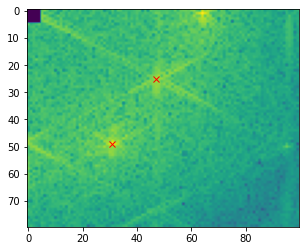

In [54]:
plt.imshow(roi)
plt.plot(peaks[:, 1], peaks[:, 0], 'rx')

In [47]:
peak = peaks[0]

In [48]:
peak

array([49, 31])

In [44]:
angle = np.arctan(peak[1]/peak[0])
angle*180/np.pi

32.31961650818018

In [45]:
dist = np.sqrt(peak[1]**2+peak[0]**2)
dist

57.982756057296896

In [49]:
im.shape

(1937, 2221)

In [56]:
yfreq = np.fft.fftfreq(dimpled_points.y.max(), 1)
yfreq

array([ 0.        ,  0.00051626,  0.00103252, ..., -0.00154879,
       -0.00103252, -0.00051626])

In [58]:
xfreq = np.fft.fftfreq(dimpled_points.x.max(), 1)
xfreq

array([ 0.        ,  0.00045025,  0.0009005 , ..., -0.00135074,
       -0.0009005 , -0.00045025])

In [59]:
peak

array([49, 31])

In [60]:
peakx_k = xfreq[peak[1]]
peaky_k = yfreq[peak[0]]

In [62]:
angle = np.arctan(peaky_k/peakx_k)
angle * 180/np.pi

61.112040393064134

In [63]:
dist = np.sqrt(peakx_k**2+peaky_k**2)
dist

0.02889199542934469